In [1]:
import os
# os.chdir(r"/content/drive/MyDrive/billing_features/raw/")
import math
import time
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import missingno as msno
import pickle
import lightgbm
import xgboost as xgb
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import utils

In [3]:
file="policy_premium_pickle"
data_dir="/app/models/dij22"
policy_premium_df=pd.read_pickle(os.path.join(data_dir,file))

In [4]:
data_dir="/app/models/trident/retention/engineered_update_2022_06"
churn_labels = pd.read_csv(os.path.join(data_dir,'churn_labels.csv'))
churn_labels.dropna(subset=['churn'],inplace=True)
# churn_labels['policy_id']=churn_labels['policy_id'].astype(int)
# churn_labels['year']=churn_labels['year'].apply(int)
# churn_labels.shape

In [28]:
# positive_sample=churn_labels[churn_labels.churn==1]
# check1=0
# check2=0
# for index,row in tqdm(positive_sample.iterrows(), total=positive_sample.shape[0]):
    
#     if pd.to_datetime(row["policy_anniv_dt"])==pd.to_datetime(row["policy_term_dt"]):
#         check1+=1
        
#     if np.isnan(pd.to_datetime(row["policy_term_dt"]).month):
#         check2+=1


# print(f"Among all churn policy {positive_sample.shape[0]:,}, there are {check1/positive_sample.shape[0]:.2%} data whose policy_anniv_dt==policy_term_dt")
# # print(f"There are {check2:,} policies that churn==1 and policy_term_dt is missing")

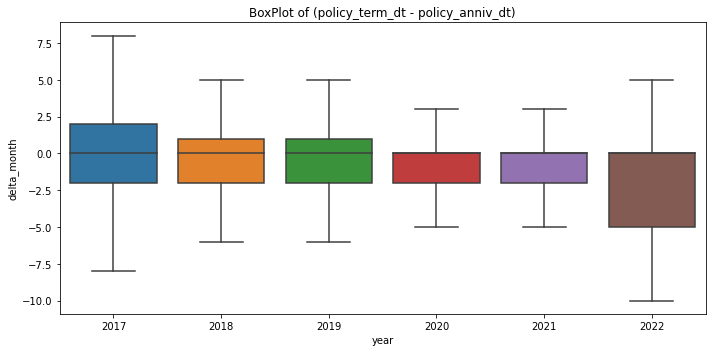

In [29]:
positive_sample=churn_labels[churn_labels.churn==1]
# positive_sample["anniv_month"]=pd.to_datetime(positive_sample["policy_anniv_dt"]).month
positive_sample["delta_month"]=(pd.to_datetime(positive_sample["policy_term_dt"])-pd.to_datetime(positive_sample["policy_anniv_dt"]))/np.timedelta64(1, 'M')
positive_sample["delta_month"]=positive_sample["delta_month"].apply(int)
# positive_sample["delta_month"]=positive_sample["policy_term_month"]-positive_sample["anniv_month"]
# positive_sample["delta_month"]=positive_sample["delta_month"].apply(int)


var="delta_month"
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# fig = plt.subplots(nrows=1,ncols=5,figsize =(15, 6))
# plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = positive_sample, x='year',y=var, showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = positive_sample, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title("BoxPlot of (policy_term_dt - policy_anniv_dt)")

plt.show()

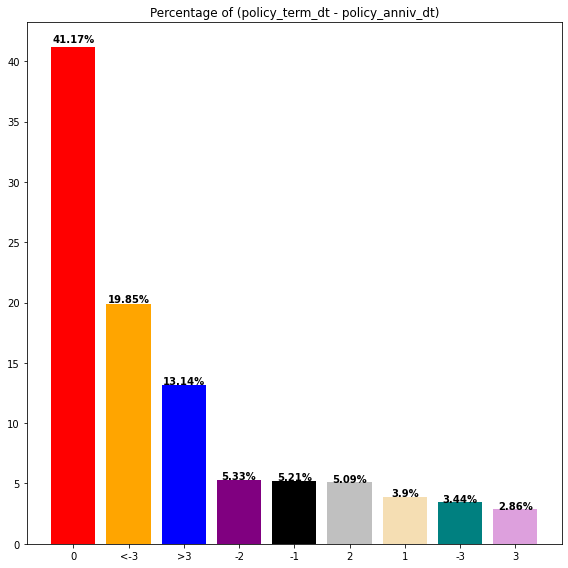

In [34]:
# positive_sample["delta_month"]=positive_sample["delta_month"].astype(str)
def myfunc(x):
    if x>3:
        return ">3"
    elif x<-3:
        return "<-3"
    else:
        return x
    
positive_sample["delta_month_cat"]=positive_sample["delta_month"].apply(myfunc)
tempt=positive_sample["delta_month_cat"].value_counts(dropna=False, normalize=True).to_frame().reset_index().rename(columns={"index":"delta_month","delta_month_cat":"percentage"})
tempt.percentage=tempt.percentage*100
tempt.delta_month=tempt.delta_month.astype(str)
tempt.percentage=tempt.percentage.astype(float)
tempt.percentage=tempt.percentage.round(decimals = 2)

plt.figure(figsize=(8,8))
colors_list = ['Red','Orange', 'Blue', 'Purple','Black',"silver","wheat","teal","plum"]
graph = plt.bar(tempt.delta_month,tempt.percentage, color = colors_list)
plt.title('Percentage of (policy_term_dt - policy_anniv_dt)')
 
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(tempt.percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

In [27]:
positive_sample["delta_month_cat"].value_counts(dropna=False, normalize=True).to_frame().reset_index().rename(columns={"index":"delta_month","delta_month_cat":"percentage"})

,delta_month,percentage
0,0,0.411669
1,<-3,0.198516
2,>3,0.131431
3,-2,0.053268
4,-1,0.052129
5,2,0.050949
6,1,0.039031
7,-3,0.034372
8,3,0.028634


### Yearly Based Data
- every policy_id only has one observation in every year
- 

In [5]:
def data_merge_yearly(churn_df, policy_df, buffer):
    policy_id=[]
    policy_anniv_dt=[]
    orig_policy_eff_dt=[]
    policy_term_dt=[]
    year=[]
    month=[]
    pivot_date=[]
    survival_month=[]
    churn=[]
    for index,row in tqdm(churn_df.iterrows(), total=churn_df.shape[0]):           
            
        policy_term_month=pd.to_datetime(row["policy_term_dt"]).month
        policy_anniv_month=pd.to_datetime(row["policy_anniv_dt"]).month
        if np.isnan(policy_term_month):
            date1=str(row["year"])+str(int(policy_anniv_month))
            date2=pd.to_datetime(str(date1),format="%Y%m")
        else:
            date1=str(row["year"])+str(int(policy_term_month))
            date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer)

        policy_id.append(row["policy_id"])
        year.append(date2.year)
        month.append(date2.month)
        
        if int(date1[4:])<10:
            date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)
        
        
        x2=pd.to_datetime(row["target_dt"])
        x1=pd.to_datetime(row["orig_policy_eff_dt"])
        survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
        
        policy_anniv_dt.append(row["policy_anniv_dt"])
        policy_term_dt.append(row["policy_term_dt"])
        orig_policy_eff_dt.append(row["orig_policy_eff_dt"])
        
        churn.append(row["churn"])
        
    churn_data=pd.DataFrame({"policy_id":policy_id,"orig_policy_eff_dt":orig_policy_eff_dt,"policy_anniv_dt":policy_anniv_dt,"policy_term_dt":policy_term_dt,
                             "pivot_date":pivot_date,"year":year,"month":month,"survival_month":survival_month,"churn":churn})
    # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data.drop_duplicates(inplace=True)
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    
    df=pd.merge(churn_data,policy_df,how="inner", on=["policy_id", "year","month"])
    df.sort_values(by=["policy_id","year"],ascending=True,inplace=True)
    
    return churn_data, df

In [6]:
churn_0, df_buffer_0=data_merge_yearly(churn_labels,policy_premium_df, buffer=0)
churn_1, df_buffer_1=data_merge_yearly(churn_labels,policy_premium_df, buffer=1)
churn_2, df_buffer_2=data_merge_yearly(churn_labels,policy_premium_df, buffer=2)
churn_3, df_buffer_3=data_merge_yearly(churn_labels,policy_premium_df, buffer=3)

100%|██████████| 445577/445577 [07:23<00:00, 1004.93it/s]


In [ ]:
data_dir="/app/models/dij22"
df_buffer_0.to_pickle(os.path.join(data_dir,"df_buffer_0_pickle"))
df_buffer_1.to_pickle(os.path.join(data_dir,"df_buffer_1_pickle"))
df_buffer_2.to_pickle(os.path.join(data_dir,"df_buffer_2_pickle"))
df_buffer_3.to_pickle(os.path.join(data_dir,"df_buffer_3_pickle"))

In [6]:
data_dir="/app/models/dij22"
df_buffer_0=pd.read_pickle(os.path.join(data_dir,"df_buffer_0_pickle"))
df_buffer_1=pd.read_pickle(os.path.join(data_dir,"df_buffer_1_pickle"))
df_buffer_2=pd.read_pickle(os.path.join(data_dir,"df_buffer_2_pickle"))
df_buffer_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_3_pickle"))

In [5]:
var=["policy_id","year","month","CountBillsPaidFull","CountBillsPaid" ,"CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
policy_premium_df[policy_premium_df.policy_id==151353].loc[:,var]

,policy_id,year,month,CountBillsPaidFull,CountBillsPaid,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
1544845,151353,2018,1,1.0,1.0,200.75,200.750000,200.750000,200.750000
1249084,151353,2018,2,1.0,1.0,200.75,200.750000,200.750000,200.750000
239156,151353,2018,3,1.0,1.0,200.75,200.750000,200.750000,200.750000
2394512,151353,2018,4,1.0,1.0,200.75,200.750000,200.750000,200.750000
1636609,151353,2018,5,1.0,1.0,200.75,200.750000,200.750000,200.750000
1141456,151353,2018,6,1.0,1.0,200.75,200.750000,200.750000,200.750000
350371,151353,2018,7,1.0,1.0,200.75,200.750000,200.750000,200.750000
2457090,151353,2018,8,1.0,1.0,200.75,200.750000,200.750000,200.750000
1885236,151353,2018,9,1.0,1.0,200.75,200.750000,200.750000,200.750000
1142244,151353,2018,10,0.0,0.0,0.00,133.833333,167.291667,180.675000


In [6]:
churn_labels[churn_labels.policy_id==151353]

,unum_client_id,policy_id,orig_policy_eff_dt,policy_term_dt,policy_eff_yr,policy_eff_month,policy_term_yr,policy_term_month,year,churn,policy_anniv_dt,target_dt
1042,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2017,0,2017-04-01,2017-04-01
1043,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2018,0,2018-04-01,2018-04-01
1044,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2019,0,2019-04-01,2019-04-01
1045,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2020,0,2020-04-01,2020-04-01
1046,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2021,1,2021-04-01,2021-04-01


In [7]:
var=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_1[df_buffer_1.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
769,151353,2009-04-01,2021-04-01,2018-04-01,201804,2018,3,107,0,200.75,200.750000,200.750000,200.750000
770,151353,2009-04-01,2021-04-01,2019-04-01,201904,2019,3,119,0,200.75,200.750000,167.291667,184.020833
771,151353,2009-04-01,2021-04-01,2020-04-01,202004,2020,3,132,0,140.25,180.583333,190.666667,195.708333


In [8]:
var=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_2[df_buffer_2.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
759,151353,2009-04-01,2021-04-01,2018-04-01,201804,2018,2,107,0,200.75,200.750000,200.750000,200.750000
760,151353,2009-04-01,2021-04-01,2019-04-01,201904,2019,2,119,0,200.75,200.750000,167.291667,184.020833
761,151353,2009-04-01,2021-04-01,2021-04-01,202104,2021,2,144,1,167.75,149.416667,156.750000,155.833333


In [10]:
var=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_3[df_buffer_3.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
760,151353,2009-04-01,2021-04-01,2018-04-01,201804,2018,1,107,0,200.75,200.750000,200.750000,200.750000
761,151353,2009-04-01,2021-04-01,2019-04-01,201904,2019,1,119,0,200.75,200.750000,167.291667,184.020833
762,151353,2009-04-01,2021-04-01,2020-04-01,202004,2020,1,132,0,200.75,200.750000,200.750000,200.750000
763,151353,2009-04-01,2021-04-01,2021-04-01,202104,2021,1,144,1,162.25,149.416667,155.833333,158.583333


<Figure size 720x576 with 0 Axes>

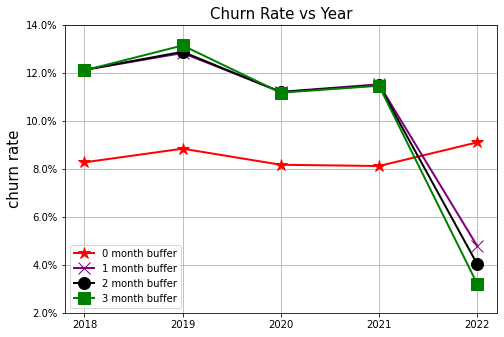

In [9]:
churn_year_0=df_buffer_0.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_0.style.format({"churn":"{.2%}"})
churn_year_1=df_buffer_1.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_1.style.format({"churn":"{.2%}"})
churn_year_2=df_buffer_2.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_2.style.format({"churn":"{.2%}a"})
churn_year_3=df_buffer_3.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_3.style.format({"churn":"{.2%}"})

plt.figure(figsize=(10,8))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes

ax.plot(churn_year_0["year"],churn_year_0["churn"],color="r",marker="*",linewidth=2, markersize=12,label="0 month buffer")
ax.plot(churn_year_1["year"],churn_year_1["churn"],color="purple",marker="x",linewidth=2, markersize=12,label="1 month buffer")
ax.plot(churn_year_2["year"],churn_year_2["churn"],color="black",marker="o",linewidth=2, markersize=12,label="2 month buffer")
ax.plot(churn_year_3["year"],churn_year_3["churn"],color="green",marker="s",linewidth=2, markersize=12,label="3 month buffer")

ax.set_title("Churn Rate vs Year",fontsize=15)
ax.legend()
ax.set_ylabel("churn rate",fontsize=15)
ax.set_xticks([2018,2019,2020,2021,2022])
ax.set_ylim([0.02,0.14])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.grid()
plt.tight_layout()
plt.show()


In [15]:
temp0=churn_0.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"0 month buffer"})
temp1=churn_1.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"1 month buffer"})
temp2=churn_2.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"2 month buffer"})
temp3=churn_3.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"3 month buffer"})
temp=pd.merge(temp0,temp1,on=['year','month'],how="inner")
temp=pd.merge(temp,temp2,on=['year','month'],how="inner")
temp=pd.merge(temp,temp3,on=['year','month'],how="inner")
temp.style.format({"0 month buffer":"{:,}","1 month buffer":"{:,}","2 month buffer":"{:,}","3 month buffer":"{:,}"})\
    .set_caption("The number of churn occurence")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

,year,month,0 month buffer,1 month buffer,2 month buffer,3 month buffer
0,2017,1,"2,433",416,421,585
1,2017,2,416,421,585,494
2,2017,3,421,585,494,513
3,2017,4,585,494,513,838
4,2017,5,494,513,838,536
5,2017,6,513,838,536,518
6,2017,7,838,536,518,614
7,2017,8,536,518,614,455
8,2017,9,518,614,455,747
9,2017,10,614,455,747,"2,699"


In [16]:
temp0=df_buffer_0.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"0 month buffer"})
temp1=df_buffer_1.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"1 month buffer"})
temp2=df_buffer_2.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"2 month buffer"})
temp3=df_buffer_3.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"3 month buffer"})
temp=pd.merge(temp0,temp1,on=['year','month'],how="inner")
temp=pd.merge(temp,temp2,on=['year','month'],how="inner")
temp=pd.merge(temp,temp3,on=['year','month'],how="inner")
temp.style.format({"0 month buffer":"{:,}","1 month buffer":"{:,}","2 month buffer":"{:,}","3 month buffer":"{:,}"})\
    .set_caption("The number of churn occurence")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

,year,month,0 month buffer,1 month buffer,2 month buffer,3 month buffer
0,2018,1,"1,682",450,505,574
1,2018,2,326,499,564,523
2,2018,3,388,563,521,620
3,2018,4,371,531,620,794
4,2018,5,399,621,782,451
5,2018,6,423,779,454,570
6,2018,7,575,465,580,608
7,2018,8,380,573,598,494
8,2018,9,402,595,496,696
9,2018,10,441,501,703,"2,850"


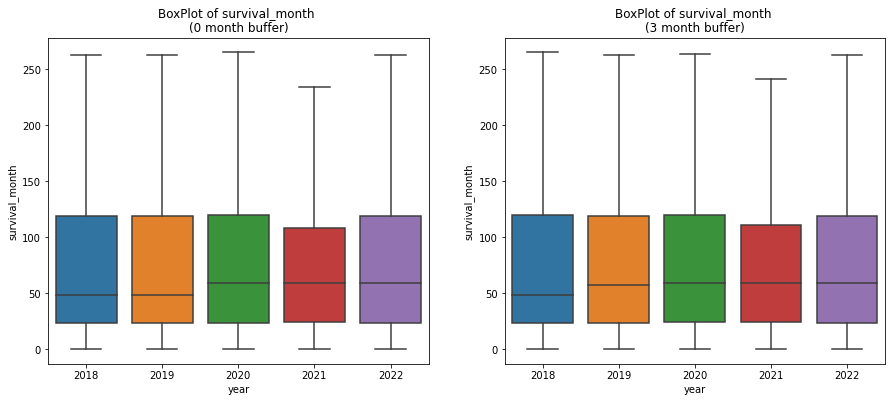

In [17]:
var="survival_month"
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()


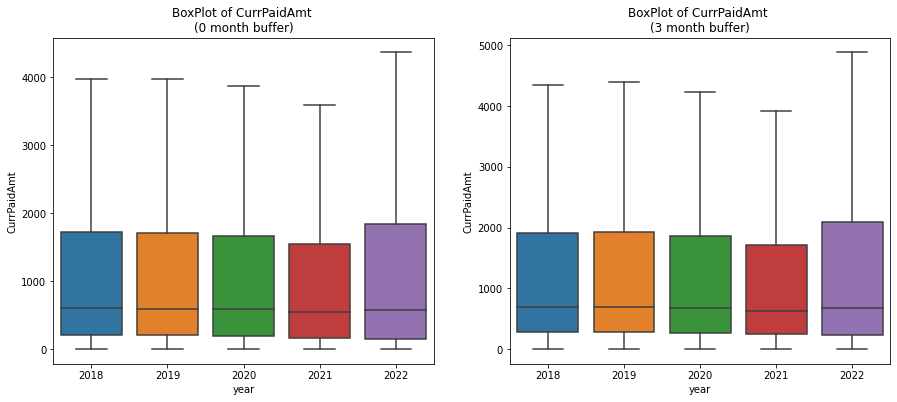

In [18]:
var="CurrPaidAmt"
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()


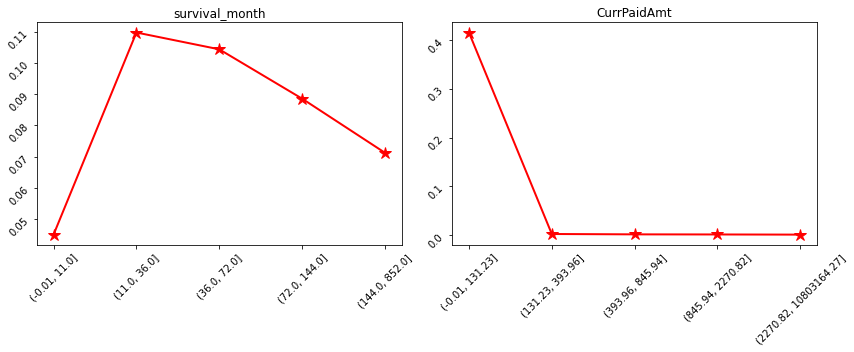

In [15]:

variable_list=["survival_month","CurrPaidAmt"]
nbin=5
args=[]
for idx,v in enumerate(variable_list):
    x=utils.pcut_func(df_buffer_0,var=variable_list[idx],nbin=nbin)
    args.append(x)

utils.myplot(df_buffer_0,variable_list,*args)

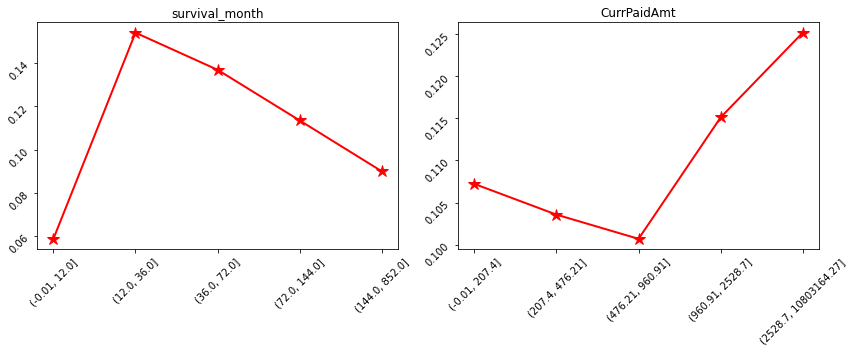

In [10]:
variable_list=["survival_month","CurrPaidAmt"]
nbin=5
args=[]
for idx,v in enumerate(variable_list):
    x=utils.pcut_func(df_buffer_3,var=variable_list[idx],nbin=nbin)
    args.append(x)

utils.myplot(df_buffer_3,variable_list,*args)

In [9]:
tempt1=df_buffer_3[df_buffer_3["churn"]==1].loc[:,'survival_month'].value_counts(dropna=True,normalize=False).to_frame().reset_index()
tempt0=df_buffer_3[df_buffer_3["churn"]==0].loc[:,'survival_month'].value_counts(dropna=True,normalize=False).to_frame().reset_index()
tempt1

,index,survival_month
0,48,2573
1,36,2564
2,11,2291
3,23,2142
4,24,1802
...,...,...
462,313,1
463,425,1
464,337,1
465,442,1


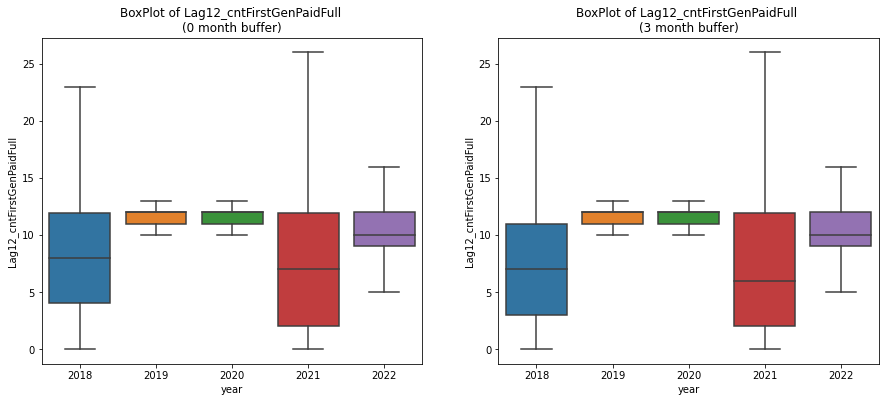

In [19]:
var="Lag12_cntFirstGenPaidFull"
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()

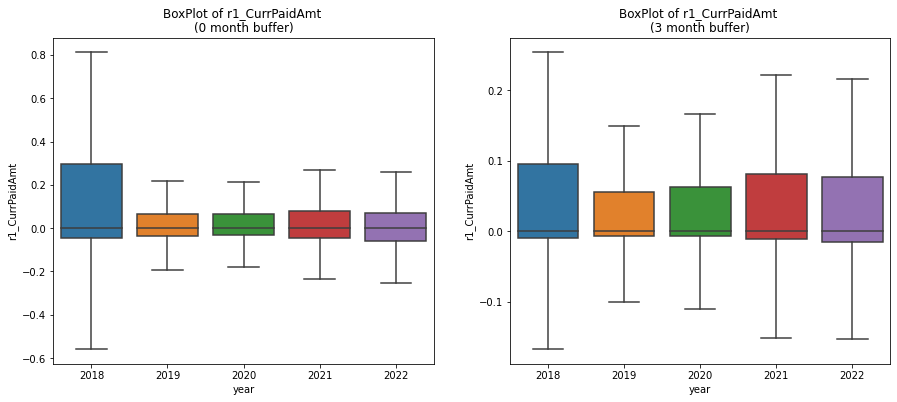

In [20]:
var="r1_CurrPaidAmt"
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()

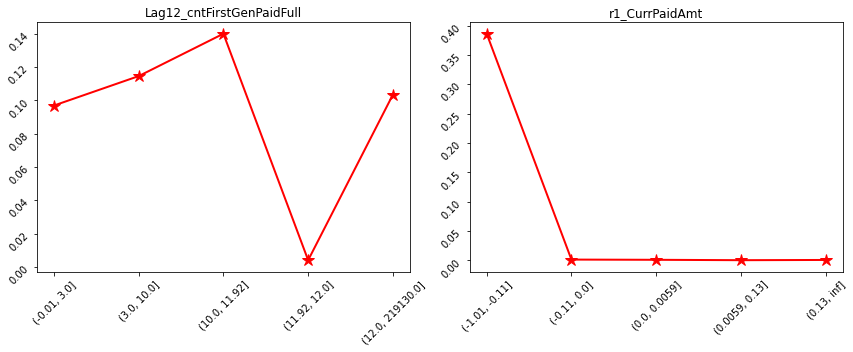

In [13]:

variable_list=["Lag12_cntFirstGenPaidFull","r1_CurrPaidAmt"]
nbin=5
args=[]
for idx,v in enumerate(variable_list):
    x=utils.pcut_func(df_buffer_0,var=variable_list[idx],nbin=nbin)
    args.append(x)

utils.myplot(df_buffer_0,variable_list,*args)

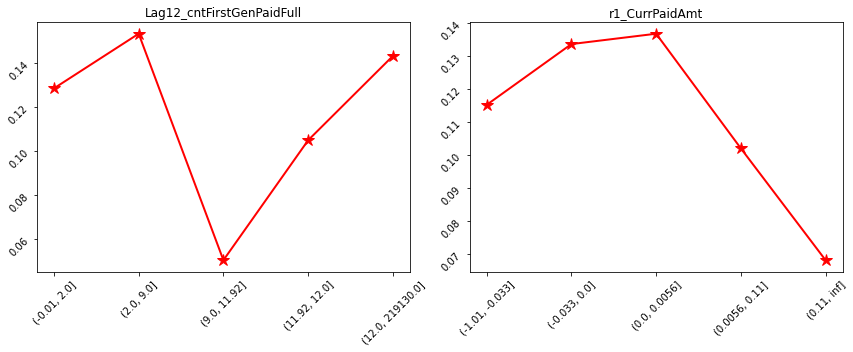

In [14]:

variable_list=["Lag12_cntFirstGenPaidFull","r1_CurrPaidAmt"]
nbin=5
args=[]
for idx,v in enumerate(variable_list):
    x=utils.pcut_func(df_buffer_3,var=variable_list[idx],nbin=nbin)
    args.append(x)

utils.myplot(df_buffer_3,variable_list,*args)

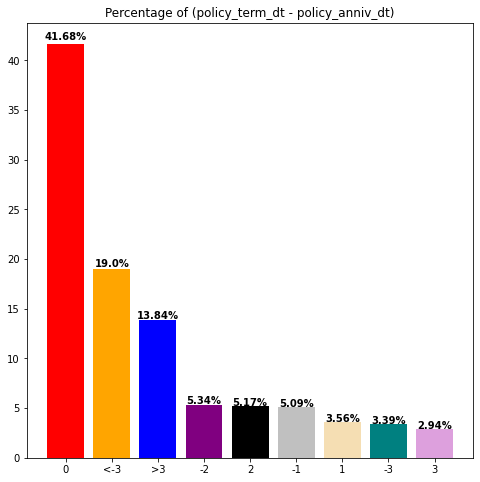

In [5]:
data_dir="/app/models/dij22"
df_buffer_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_3_pickle"))

positive_sample=df_buffer_3[df_buffer_3.churn==1]
# positive_sample["anniv_month"]=pd.to_datetime(positive_sample["policy_anniv_dt"]).month
positive_sample["delta_month"]=(pd.to_datetime(positive_sample["policy_term_dt"])-pd.to_datetime(positive_sample["policy_anniv_dt"]))/np.timedelta64(1, 'M')
positive_sample["delta_month"]=positive_sample["delta_month"].apply(int)

def myfunc(x):
    if x>3:
        return ">3"
    elif x<-3:
        return "<-3"
    else:
        return x
    
positive_sample["delta_month_cat"]=positive_sample["delta_month"].apply(myfunc)
tempt=positive_sample["delta_month_cat"].value_counts(dropna=False, normalize=True).to_frame().reset_index().rename(columns={"index":"delta_month","delta_month_cat":"percentage"})
tempt.percentage=tempt.percentage*100
tempt.delta_month=tempt.delta_month.astype(str)
tempt.percentage=tempt.percentage.astype(float)
tempt.percentage=tempt.percentage.round(decimals = 2)

plt.figure(figsize=(8,8))
colors_list = ['Red','Orange', 'Blue', 'Purple','Black',"silver","wheat","teal","plum"]
graph = plt.bar(tempt.delta_month,tempt.percentage, color = colors_list)
plt.title('Percentage of (policy_term_dt - policy_anniv_dt)')
 
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(tempt.percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

### Monthly Based Data
- every policy_id only has a fixed length monthly observation in every year
- Given a pivot_date, a fixed window monthly data was traced back to consider the trend prior to churn

In [ ]:
def data_merge_monthly(churn_df, policy_df, fixed_window, buffer):
    policy_id=[]
    policy_anniv_dt=[]
    orig_policy_eff_dt=[]
    policy_term_dt=[]
    year=[]
    month=[]
    pivot_date=[]
    survival_month=[]
    churn=[]
    for index,row in tqdm(churn_df.iterrows(), total=churn_df.shape[0]):
        policy_term_month=pd.to_datetime(row["policy_term_dt"]).month
        policy_anniv_month=pd.to_datetime(row["policy_anniv_dt"]).month
        if np.isnan(policy_term_month):
            date1=str(row["year"])+str(int(policy_anniv_month))
            for t in range(0, fixed_window+0+2*fixed_window,3): ## if not churn, don't need buffer
                date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=t)
                policy_id.append(row["policy_id"])
                year.append(date2.year)
                month.append(date2.month)
            
                # if int(date1[4:])<10:
                #     date1=date1[:4]+str(0)+date1[4:]
                pivot_date.append(date1)

                x2=pd.to_datetime(date2)
                x1=pd.to_datetime(row["orig_policy_eff_dt"])
                survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
                
                policy_anniv_dt.append(row["policy_anniv_dt"])
                policy_term_dt.append(row["policy_term_dt"])
                orig_policy_eff_dt.append(row["orig_policy_eff_dt"])
                
                churn.append(0)
            
            
        else:
            date1=str(row["year"])+str(int(policy_term_month))
        
            for t in range(buffer, fixed_window+buffer+2*fixed_window,3): ## if churn, need buffer

                date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=t)
                policy_id.append(row["policy_id"])
                year.append(date2.year)
                month.append(date2.month)
            
                # if int(date1[4:])<10:
                #     date1=date1[:4]+str(0)+date1[4:]
                pivot_date.append(date1)

                x2=pd.to_datetime(date2)
                x1=pd.to_datetime(row["orig_policy_eff_dt"])
                survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
                
                policy_anniv_dt.append(row["policy_anniv_dt"])
                policy_term_dt.append(row["policy_term_dt"])
                orig_policy_eff_dt.append(row["orig_policy_eff_dt"])

                if date2==pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer) and row["churn"]==1:
                    churn.append(1)
                else:
                    churn.append(0)
                
                
        # ## Add the decision point on anniversary date
        # if (pd.to_datetime(row["policy_anniv_dt"]).year not in year) and (pd.to_datetime(row["policy_anniv_dt"]).month not in month):
        #     policy_id.append(row["policy_id"])
        #     year.append(pd.to_datetime(row["policy_anniv_dt"]).year)
        #     month.append(pd.to_datetime(row["policy_anniv_dt"]).month)
        
        #     # if int(date1[4:])<10:
        #     #     date1=date1[:4]+str(0)+date1[4:]
        #     pivot_date.append(date1)
            
        #     x2=pd.to_datetime(row["policy_anniv_dt"])
        #     x1=pd.to_datetime(row["orig_policy_eff_dt"])
        #     survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
            
        #     policy_anniv_dt.append(row["policy_anniv_dt"])
        #     policy_term_dt.append(row["policy_term_dt"])
        #     orig_policy_eff_dt.append(row["orig_policy_eff_dt"])
            
        #     if pd.to_datetime(row["policy_anniv_dt"])==pd.to_datetime(row["policy_term_dt"]) and row["churn"]==1:
        #         churn.append(1)
        #     else:
        #         churn.append(0)
            
                   
    churn_data=pd.DataFrame({"policy_id":policy_id,"orig_policy_eff_dt":orig_policy_eff_dt,"policy_anniv_dt":policy_anniv_dt,"policy_term_dt":policy_term_dt,
                            "pivot_date":pivot_date,"year":year,"month":month,"survival_month":survival_month,"churn":churn})
    
    churn_data.drop_duplicates(inplace=True)
        # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    
    df=pd.merge(churn_data,policy_df,how="inner", on=["policy_id", "year","month"])
    df.sort_values(by=["policy_id","year","month"],ascending=True,inplace=True)
    
    return df

In [ ]:
data_dir="/app/models/dij22"

df_buffer_0_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=0)
df_buffer_0_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_0_hist_3_pickle"))

df_buffer_1_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=1)
df_buffer_1_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_1_hist_3_pickle"))

df_buffer_2_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=2)
df_buffer_2_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_2_hist_3_pickle"))

df_buffer_3_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=3)
df_buffer_3_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_3_hist_3_pickle"))

# df_buffer_0_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=0)
# df_buffer_0_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_0_hist_6_pickle"))

# df_buffer_1_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=1)
# df_buffer_1_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_1_hist_6_pickle"))

# df_buffer_2_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=2)
# df_buffer_2_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_2_hist_6_pickle"))

# df_buffer_3_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=3)
# df_buffer_3_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_3_hist_6_pickle"))


In [43]:
data_dir="/app/models/dij22"
df_buffer_0_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_0_hist_3_pickle"))
df_buffer_1_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_1_hist_3_pickle"))
df_buffer_2_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_2_hist_3_pickle"))
df_buffer_3_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_3_hist_3_pickle"))

In [28]:
var=["policy_id","year","month","CountBillsPaidFull","CountBillsPaid" ,"CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
policy_premium_df[policy_premium_df.policy_id==151353].loc[:,var]

,policy_id,year,month,CountBillsPaidFull,CountBillsPaid,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
1544845,151353,2018,1,1.0,1.0,200.75,200.750000,200.750000,200.750000
1249084,151353,2018,2,1.0,1.0,200.75,200.750000,200.750000,200.750000
239156,151353,2018,3,1.0,1.0,200.75,200.750000,200.750000,200.750000
2394512,151353,2018,4,1.0,1.0,200.75,200.750000,200.750000,200.750000
1636609,151353,2018,5,1.0,1.0,200.75,200.750000,200.750000,200.750000
1141456,151353,2018,6,1.0,1.0,200.75,200.750000,200.750000,200.750000
350371,151353,2018,7,1.0,1.0,200.75,200.750000,200.750000,200.750000
2457090,151353,2018,8,1.0,1.0,200.75,200.750000,200.750000,200.750000
1885236,151353,2018,9,1.0,1.0,200.75,200.750000,200.750000,200.750000
1142244,151353,2018,10,0.0,0.0,0.00,133.833333,167.291667,180.675000


In [23]:
churn_labels[churn_labels.policy_id==151353]

,unum_client_id,policy_id,orig_policy_eff_dt,policy_term_dt,policy_eff_yr,policy_eff_month,policy_term_yr,policy_term_month,year,churn,policy_anniv_dt,target_dt
1042,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2017,0,2017-04-01,2017-04-01
1043,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2018,0,2018-04-01,2018-04-01
1044,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2019,0,2019-04-01,2019-04-01
1045,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2020,0,2020-04-01,2020-04-01
1046,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2021,1,2021-04-01,2021-04-01


In [26]:
bvar=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_1_hist_3[df_buffer_1_hist_3.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
2044,151353,2009-04-01,2021-04-01,2018-04-01,20184,2018,3,106,0,200.75,200.750000,200.750000,200.750000
2047,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,9,113,0,200.75,200.750000,200.750000,200.750000
2046,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,12,116,0,200.75,133.833333,167.291667,184.020833
2045,151353,2009-04-01,2021-04-01,2019-04-01,20194,2019,3,118,0,200.75,200.750000,167.291667,184.020833
2050,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,9,125,0,200.75,200.750000,200.750000,184.020833
2049,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,12,128,0,200.75,200.750000,200.750000,200.750000
2048,151353,2009-04-01,2021-04-01,2020-04-01,20204,2020,3,130,0,140.25,180.583333,190.666667,195.708333
2052,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,9,137,0,162.25,162.250000,158.583333,174.625000
2051,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,12,140,0,118.25,149.416667,155.833333,161.791667


In [25]:
var=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_3_hist_3[df_buffer_3_hist_3.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
2012,151353,2009-04-01,2021-04-01,2018-04-01,20184,2018,1,105,0,200.75,200.750000,200.750000,200.750000
2015,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,7,110,0,200.75,200.750000,200.750000,200.750000
2014,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,10,114,0,0.00,133.833333,167.291667,180.675000
2013,151353,2009-04-01,2021-04-01,2019-04-01,20194,2019,1,117,0,200.75,200.750000,167.291667,184.020833
2018,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,7,122,0,200.75,200.750000,200.750000,184.020833
2017,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,10,125,0,200.75,200.750000,200.750000,200.750000
2016,151353,2009-04-01,2021-04-01,2020-04-01,20204,2020,1,129,0,200.75,200.750000,200.750000,200.750000
2021,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,7,135,0,162.25,158.583333,161.333333,181.041667
2020,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,10,138,0,162.25,162.250000,160.416667,171.416667
2019,151353,2009-04-01,2021-04-01,2021-04-01,20214,2021,1,141,1,162.25,149.416667,155.833333,158.583333


In [27]:
var=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_1_hist_3[df_buffer_1_hist_3.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
2044,151353,2009-04-01,2021-04-01,2018-04-01,20184,2018,3,106,0,200.75,200.750000,200.750000,200.750000
2047,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,9,113,0,200.75,200.750000,200.750000,200.750000
2046,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,12,116,0,200.75,133.833333,167.291667,184.020833
2045,151353,2009-04-01,2021-04-01,2019-04-01,20194,2019,3,118,0,200.75,200.750000,167.291667,184.020833
2050,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,9,125,0,200.75,200.750000,200.750000,184.020833
2049,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,12,128,0,200.75,200.750000,200.750000,200.750000
2048,151353,2009-04-01,2021-04-01,2020-04-01,20204,2020,3,130,0,140.25,180.583333,190.666667,195.708333
2052,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,9,137,0,162.25,162.250000,158.583333,174.625000
2051,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,12,140,0,118.25,149.416667,155.833333,161.791667


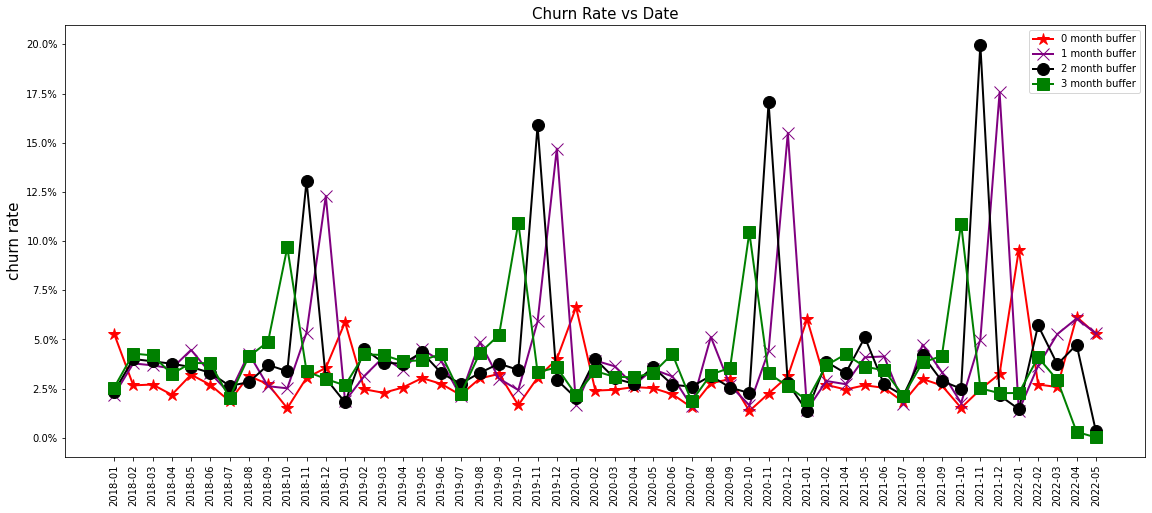

In [55]:
# churn_year_0_hist_3=df_buffer_0_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
# churn_year_0_hist_3['date']=churn_year_0_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# # churn_year_0_hist_3.style.format({"churn":"{.2%}"})
# churn_year_1_hist_3=df_buffer_1_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
# churn_year_1_hist_3['date']=churn_year_1_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# # churn_year_1_hist_3.style.format({"churn":"{.2%}"})
# churn_year_2_hist_3=df_buffer_2_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
# churn_year_2_hist_3['date']=churn_year_2_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# # churn_year_2_hist_3.style.format({"churn":"{.2%}a"})
# churn_year_3_hist_3=df_buffer_3_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
# churn_year_3_hist_3['date']=churn_year_3_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# # churn_year_3_hist_3.style.format({"churn":"{.2%}"})


fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1]) # main axes

ax.plot(churn_year_0_hist_3["date"],churn_year_0_hist_3["churn"],color="r",marker="*",linewidth=2, markersize=12,label="0 month buffer")
ax.plot(churn_year_1_hist_3["date"],churn_year_1_hist_3["churn"],color="purple",marker="x",linewidth=2, markersize=12,label="1 month buffer")
ax.plot(churn_year_2_hist_3["date"],churn_year_2_hist_3["churn"],color="black",marker="o",linewidth=2, markersize=12,label="2 month buffer")
ax.plot(churn_year_3_hist_3["date"],churn_year_3_hist_3["churn"],color="green",marker="s",linewidth=2, markersize=12,label="3 month buffer")

ax.set_title("Churn Rate vs Date",fontsize=15)
ax.legend()
ax.set_ylabel("churn rate",fontsize=15)
# ax.set_xticks([2018,2019,2020,2021,2022])
# ax.set_ylim([0,0.1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

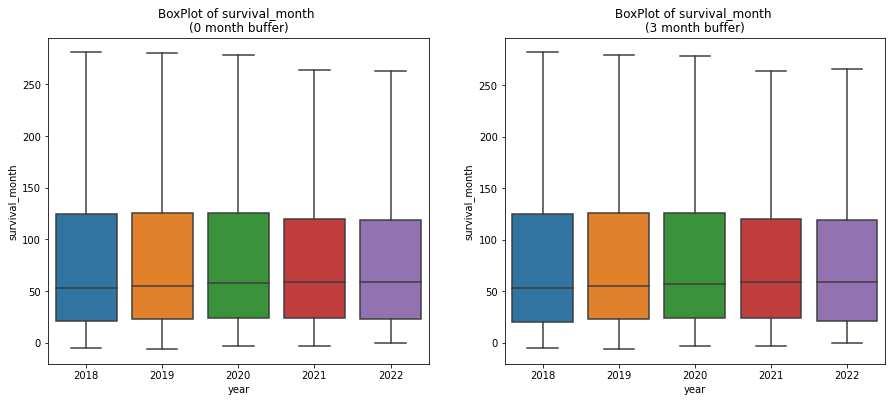

In [57]:
var="survival_month"
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
ax = sns.boxplot(data = df_buffer_0_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()

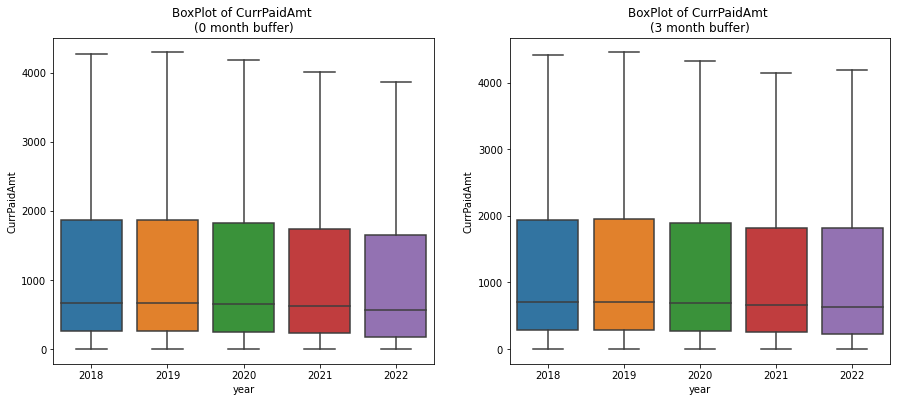

In [58]:
var="CurrPaidAmt"
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
ax = sns.boxplot(data = df_buffer_0_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()

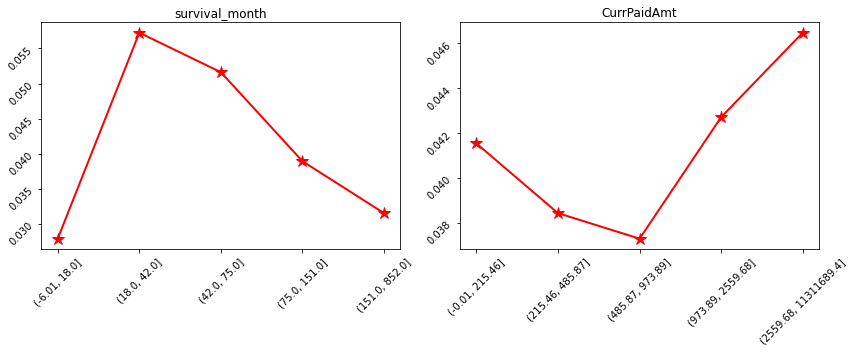

In [61]:
variable_list=["survival_month","CurrPaidAmt"]
nbin=5
args=[]
for idx,v in enumerate(variable_list):
    x=utils.pcut_func(df_buffer_3_hist_3,var=variable_list[idx],nbin=nbin)
    args.append(x)

utils.myplot(df_buffer_3_hist_3,variable_list,*args)

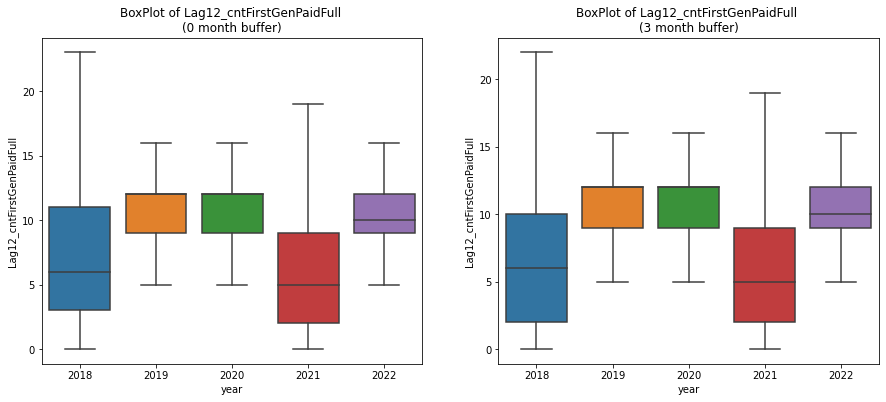

In [59]:
var="Lag12_cntFirstGenPaidFull"
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
ax = sns.boxplot(data = df_buffer_0_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()

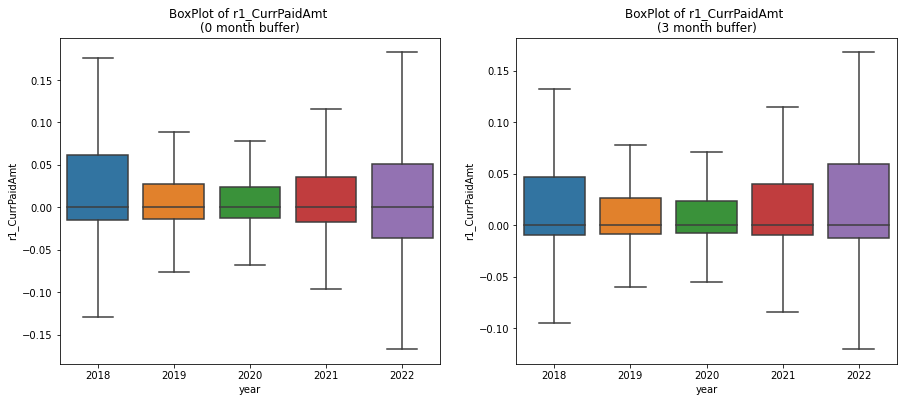

In [60]:
var="r1_CurrPaidAmt"
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
ax = sns.boxplot(data = df_buffer_0_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3_hist_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()